In [1]:
import pandas as pd

df = pd.read_csv("data/df_indi_works.csv", index_col=0)
regions = pd.read_csv('data/ENS - Cultural Index - Countries Databases - region_level.csv')
regions = regions[regions['level'] == 2]
regions = set(regions['region_name'])
df = df[df['region_name'].isin(regions)]
df["century"] = df["decade"].round(-2)
df.head(n=10)

,individual_wikidata_id,birthyear,productive_year,decade,individual_name,region_code,region_name,count_works,century
2,Q202809,1803.0,1838.0,1840,Frederick Coombs,re_united_kingdom,United Kingdom,0.0,1800
4,Q4350107,1785.0,1820.0,1820,Vassili Perevoštšikov,re_eastern_europe,Eastern Europe,0.0,1800
5,Q4350107,1785.0,1820.0,1820,Vassili Perevoštšikov,re_slav_world,Slav world,0.0,1800
8,Q1028749,1683.0,1718.0,1720,Christian Friedrich Zincke,re_united_kingdom,United Kingdom,22.0,1700
12,Q2822993,1100.0,1135.0,1140,Achard of Saint-Victor,re_united_kingdom,United Kingdom,0.0,1100
16,Q105607234,1787.0,1822.0,1820,Angelo Dalbon,re_italy,Italy,0.0,1800
20,Q91771,1570.0,1605.0,1600,Hans Krumpper,re_german_world,German world,1.0,1600
24,Q5362982,1528.0,1563.0,1560,Elizabeth Hoby,re_united_kingdom,United Kingdom,0.0,1600
29,Q3166657,1805.0,1840.0,1840,Jean-Louis Brian,re_france,France,2.0,1800
30,Q735988,1418.0,1453.0,1450,Niccolò di Giovanni Fiorentino,re_eastern_europe,Eastern Europe,0.0,1400


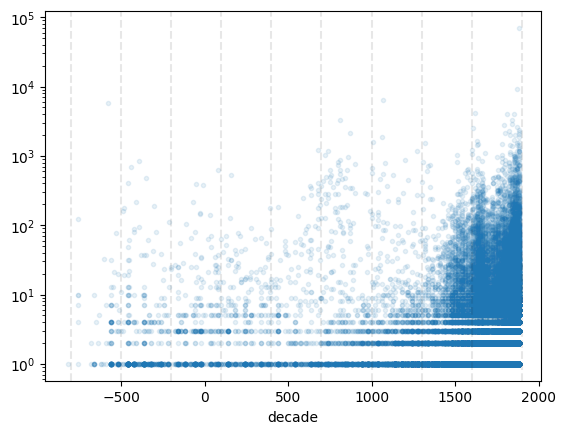

In [2]:
import matplotlib.pyplot as plt
import numpy as np

num_knots = 10
knots = np.linspace(df["century"].min(), df["century"].max(), num_knots)

fig, ax = plt.subplots()
(df.groupby(["decade", "individual_wikidata_id"])["count_works"].sum() + 1).droplevel(
    level="individual_wikidata_id").plot(style=".", alpha=0.1, logy=True, ax=ax)

for knot in knots:
    ax.axvline(knot, color="0.1", alpha=0.1, ls="--")

In [3]:
df['count'] = df['count_works']
df_m = df.copy()
df_m = df_m[df_m['count'].isin({0, 1, 2})]
df_m['y'] = df_m['count'].map({0: 0, 1: 0, 2: 1})
df_m.sample(10)

,individual_wikidata_id,birthyear,productive_year,decade,individual_name,region_code,region_name,count_works,century,count,y
1451,Q23008985,1727.0,1762.0,1760,Ike Gyokuran,re_japan,Japan,2.0,1800,2.0,1
230431,Q321238,1813.0,1848.0,1850,Arthur Helps,re_united_kingdom,United Kingdom,0.0,1800,0.0,0
212055,Q94799842,1834.0,1869.0,1870,Adalmar Breden,re_german_world,German world,0.0,1900,0.0,0
128094,Q19283965,1845.0,1880.0,1880,Germano Wanderley,re_central_europe,Central Europe,1.0,1900,1.0,0
383462,Q1231920,1763.0,1798.0,1800,Franz Ferdinand von Druffel,re_german_world,German world,0.0,1800,0.0,0
422666,Q1386955,1739.0,1774.0,1770,James Craig,re_united_kingdom,United Kingdom,0.0,1800,0.0,0
24417,Q1317338,1718.0,1753.0,1750,Johann Friedrich Stahl,re_german_world,German world,0.0,1800,0.0,0
115150,Q1038315,1824.0,1859.0,1860,Carl Goebel,re_german_world,German world,1.0,1900,1.0,0
299511,Q2832837,1201.0,1236.0,1240,Alessandro della Spina,re_italy,Italy,0.0,1200,0.0,0
142593,Q46998234,1820.0,1855.0,1860,Elselina Angenita Cornelia Röder,re_low_countries,Low countries,1.0,1900,1.0,0


## Global B-Spline Analysis

In [4]:
import bambi as bmb
import arviz as az

iknots = knots[1:-1]

sample = df_m

priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    "common": bmb.Prior("Normal", mu=0, sigma=5),
}

m_splines = bmb.Model(
    'y ~ bs(decade, knots=iknots, intercept=True)', sample, family='bernoulli', priors=priors)
m_splines

       Formula: y ~ bs(decade, knots=iknots, intercept=True)
        Family: bernoulli
          Link: p = logit
  Observations: 157825
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 5.0)
            bs(decade, knots=iknots, intercept=True) ~ Normal(mu: 0.0, sigma: 5.0)

In [5]:
p_splines = m_splines.fit(draws=1000, chains=4, idata_kwargs={"log_likelihood": True})
az.summary(p_splines)

Modeling the probability that y==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, bs(decade, knots=iknots, intercept=True)]


EOFError: 

In [ ]:
def plot_knots(knots, ax):
    for knot in knots:
        ax.axvline(knot, color="0.1", alpha=0.4)
    return ax

def plot_predictions(data, idata, model, region=None, ax=None, plot_knot_lines=True, color="C0"):
    if ax is None:
        fig, ax = plt.subplots()
    
    new_data = {}
    if region is not None:
        data = data[data["region_name"] == region]
        new_data["region_name"] = [region] * 500
    new_data["decade"] = np.linspace(data["decade"].min(), data["decade"].max(), num=500)
    new_data = pd.DataFrame(new_data)

    model.predict(idata, data=new_data)

    posterior_stacked = az.extract(idata)
    # Extract these predictions
    y_hat = posterior_stacked["y_mean"]

    # Compute the mean of the predictions, plotted as a single line.
    y_hat_mean = y_hat.mean("sample")

    # Compute 94% credible intervals for the predictions, plotted as bands
    hdi_data = np.quantile(y_hat, [0.11, 0.89], axis=1)

    # Plot predicted line
    ax.plot(new_data["decade"], y_hat_mean, color=color, label=region)

    # Plot credibility bands
    ax.fill_between(new_data["decade"], hdi_data[0], hdi_data[1], alpha=0.4, color=color)

    # Add knots
    if plot_knot_lines:
        plot_knots(knots, ax)
    ax.set(xlabel="time", ylabel="p(n_obs=2)")

Plot the global probability of observing a producer twice in the dataset, i.e. $p(n_{\text{obs}} = 2)$:

In [ ]:
plot_predictions(sample, p_splines, m_splines);

## Global Spline Analysis with Varying Intercepts for Region

In [ ]:
sample = df_m

priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    "common": bmb.Prior("Normal", mu=0, sigma=5),
    "1|region_name": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=5))
}

m_splines_vi = bmb.Model(
    'y ~ bs(decade, knots=iknots, intercept=True) + (1|region_name)', 
    sample, family='bernoulli', priors=priors)
m_splines_vi

In [ ]:
p_splines_vi = m_splines_vi.fit(draws=1000, chains=4, idata_kwargs={"log_likelihood": True})
az.summary(p_splines_vi)

## Varying Splines Analysis on Regions

In [ ]:
sample = df_m

priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=2.5),
    "bs(decade, knots = iknots, intercept = True)|region_name": bmb.Prior(
        "Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=2.5))
}

m_splines_vs = bmb.Model(
    'y ~ 1 + (bs(decade, knots=iknots, intercept=True)|region_name)', 
    sample, family='bernoulli', priors=priors)
m_splines_vs

In [ ]:
p_splines_vs = m_splines_vs.fit(
    draws=1000, chains=4, inference_method='nuts_numpyro')  # important to run faster and sample more efficiently
az.summary(p_splines_vs)

Plot the regional probability of observing a producer twice in the dataset over time, i.e. 𝑝(𝑛obs=2):

In [ ]:
fig, axes = plt.subplots(ncols=4, nrows=5, figsize=(10, 8), constrained_layout=True)
axes = axes.flatten()

for i, region in enumerate(sorted(df_m["region_name"].unique())):
    plot_predictions(
        sample, p_splines_vs, m_splines_vs, region, ax=axes[i], color="k", plot_knot_lines=False);
    axes[i].set(title=region, xlabel="", ylabel="")

fig.supylabel('p(n_obs=2)')
fig.supxlabel('time')

In [ ]:
def plot_estimations(data, obs_data, idata, model, region=None, ax=None, logy=False, 
                     plot_knot_lines=True, color="C0"):
    if ax is None:
        fig, ax = plt.subplots()
    
    new_data = {}
    data = data[data["region_name"] == region]
    obs_data = obs_data[obs_data["region_name"] == region]   
    
    new_data["decade"] = data["decade"].values 
    new_data["region_name"] = [region] * len(data["decade"].values)
    
    new_data = pd.DataFrame(new_data)
    
    model.predict(idata, data=new_data)

    posterior_stacked = az.extract(idata)
    # Extract these predictions
    p = posterior_stacked["y_mean"].values
    l = (2 * p) / (1 - p)
    f0 = (1 / (l + (l**2) / 2))

    decades = np.array(sorted(data["decade"].unique()))
    
    N_est = np.zeros((len(decades), f0.shape[1]))
    unseen = np.zeros((len(decades), f0.shape[1]))
    
    for i, decade in enumerate(decades):
        n_obs_di = data.loc[data["decade"] == decade, "individual_wikidata_id"].nunique()
        mask = (new_data["decade"] == decade).astype(int).values[:, None]
        f0_di = (f0 * mask).sum(0)
        S_di = n_obs_di + f0_di
        N_est[i] = S_di
        unseen[i] = f0_di

    # Compute 94% credible intervals for the predictions, plotted as bands
    hdi_data = np.quantile(N_est, [0.11, 0.89], axis=1)

    # Plot predicted line
    ax.plot(decades, N_est.mean(1), color=color, label=region)
    
    df[df["region_name"] == region].groupby("decade")["individual_wikidata_id"].count().plot(
        ax=ax, ls="--", color="red")
    
    # Plot credibility bands
    ax.fill_between(decades, hdi_data[0], hdi_data[1], alpha=0.4, color=color)

    # Add knots
    if plot_knot_lines:
        plot_knots(knots, ax)
    ax.set(xlabel="time", ylabel="Estimated diversity")
    if logy:
        ax.set_yscale("log")
    
    return unseen, N_est, hdi_data, decades

In [ ]:
plot_estimations(
    sample, df, p_splines_vs, m_splines_vs, "Low countries", color="k", plot_knot_lines=False);

In [ ]:
fig, axes = plt.subplots(ncols=4, nrows=5, figsize=(10, 8), constrained_layout=True)
axes = axes.flatten()

results = {}
for i, region in enumerate(sorted(df_m["region_name"].unique())):
    f0, N_est, hdi, decades = plot_estimations(
        sample, df, p_splines_vs, m_splines_vs, region, ax=axes[i], color="k", plot_knot_lines=False);
    axes[i].set(title=region, xlabel="", ylabel="")
    results[region] = f0, N_est, hdi, decades

fig.supylabel('Estimated diversity')
fig.supxlabel('time')

In [ ]:
def plot_trend(decades, N_est, hdi_data, color="C0", label=None, ax=None, logy=False, figsize=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # Plot predicted line
    ax.plot(decades, N_est.mean(1), color=color, label=label)

    # Plot credibility bands
    ax.fill_between(decades, hdi_data[0], hdi_data[1], alpha=0.4, color=color)

    ax.set(xlabel="time", ylabel="Estimated diversity")
    if logy:
        ax.set_yscale("log")

    return ax

In [ ]:
f0, N_est, hdi, decades = results["Low countries"]

ax = plot_trend(decades, N_est, hdi, label="Low countries")
ax.set_xlim(1200, 1900)

In [ ]:
regions = "United Kingdom", "France", "Chinese world", "Japan"

fig, ax = plt.subplots()
for i, region in enumerate(regions):
    f0, N_est, hdi, decades = results[region]
    ax = plot_trend(decades, N_est, hdi, color=f"C{i}", logy=False, label=region, ax=ax)
ax.set_xlim(1000, 1850)
ax.legend()

In [ ]:
import pickle

with open("regression-dump.pickle", "wb") as out:
    pickle.dump(results, out)

In [ ]:
table = []
for region in results:
    _, N_est, hdi, decades = results[region]
    N_est = N_est.mean(1)
    li, ui = hdi[0], hdi[1]
    print(N_est.shape, li.shape, ui.shape, decades.shape)
    table.append(pd.DataFrame({
        "N_est": N_est,
        "lower": li,
        "upper": ui,
        "decade": decades,
        "region": [region] * N_est.shape[0]
    }))
table = pd.concat(table)
table.head()

In [ ]:
table.to_csv("results/estimations.csv", index=False)